In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

In [2]:
from etherscan.accounts import Account

In [3]:
import brownie

brownie.network.connect("mainnet")

In [4]:
import requests as requests

In [5]:
block_info_response = requests.get("https://api.blockcypher.com/v1/eth/main")
current_block = block_info_response.json()['height']

In [6]:
crv_depositor_contract = "0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae"
crv_depositor_contract_obj = brownie.network.contract.Contract.from_explorer(crv_depositor_contract)

Fetching source of 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae from api.etherscan.io...


/Users/swadhinnanda/Projects/git/on-chain-analytics/venv/lib/python3.7/site-packages/brownie/network/contract.py:1239: BrownieCompilerWarning: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae: Locally compiled and on-chain bytecode do not match!
  BrownieCompilerWarning,


In [7]:
go_back = 100000
query = f"https://api.etherscan.io/api?module=account&action=txlist&address={crv_depositor_contract}&startblock={current_block-go_back}&endblock={current_block}&sort=asc&page=1&offset=10000&apikey={os.environ['ETHERSCAN_API_KEY']}"
etherscan_api_response = requests.post(query)
etherscan_api_response

<Response [200]>

In [8]:
crv_depositor_txes = etherscan_api_response.json()['result']
len(crv_depositor_txes)

504

In [9]:
example_tx = crv_depositor_txes[10]
tx_receipt = brownie.network.transaction.TransactionReceipt(example_tx['hash'])
tx_receipt.info()

Transaction was Mined 
---------------------
Tx Hash: 0x9732672d70db5e62492e44988f5b44eee3dbddc9fce601c5a91d1f5030ab833d
From: 0xF9cb2a5944654B0C9b07D2311715728e30D3eE82
To: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae
Value: 0
Function: CrvDepositor.deposit
Block: 13104401
Gas Used: 172269 / 325251 (53.0%)

Events In This Transaction
--------------------------
├── 0xD533a949740bb3306d119CC777fa900bA034cd52
│   └── Transfer
│       ├── _from: 0xF9cb2a5944654B0C9b07D2311715728e30D3eE82
│       ├── _to: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae
│       └── _value: 5310123920076595644229
│   
├── 0x62B9c7356A2Dc64a1969e19C23e4f579F9810Aa7
│   ├── Transfer
│   │   ├── _from: 0x0000000000000000000000000000000000000000
│   │   ├── _to: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae
│   │   └── _value: 5310123920076595644229
│   ├── Approval
│   │   ├── _owner: 0x8014595F2AB54cD7c604B00E9fb932176fDc86Ae
│   │   ├── _spender: 0x3Fe65692bfCD0e6CF84cB1E7d24108E434A7587e
│   │   └── _value: 0
│   └── 

In [10]:
crv_lock_txes = {'timestamp': [], 'qt': [], 'gas_price': []}
for tx in crv_depositor_txes:
    try:
        tx_receipt = brownie.network.transaction.TransactionReceipt(tx['hash'])
        if tx_receipt.fn_name == 'deposit':
            crv_lock_txes['qt'].append(tx_receipt.events[0]['_value'] * 1e-18)
            crv_lock_txes['gas_price'].append(tx_receipt.gas_price * 1e-9)
            crv_lock_txes['timestamp'].append(datetime.datetime.fromtimestamp(tx_receipt.timestamp))
    except:
        continue

In [11]:
df_crv_lock_txes = pd.DataFrame(crv_lock_txes)
df_crv_lock_txes.set_index('timestamp', inplace=True)
df_crv_lock_txes

,qt,gas_price
timestamp,,
2021-08-26 16:25:32,600.000000,74.000000
2021-08-26 16:40:55,15000.000000,73.000000
2021-08-26 19:14:49,1120.178447,127.000000
2021-08-26 19:49:22,453.508374,70.735046
2021-08-26 20:38:28,23861.187621,72.000000
...,...,...
2021-09-10 20:11:36,29456.595175,74.000000
2021-09-10 20:34:52,352.012711,82.000000
2021-09-10 20:44:50,228.044756,80.000000


In [12]:
df_crv_lock_daily = pd.DataFrame()
df_crv_lock_daily['avg_gas'] = df_crv_lock_txes.groupby(pd.Grouper(freq='1D'))['gas_price'].mean()
df_crv_lock_daily['total_locked'] = df_crv_lock_txes.groupby(pd.Grouper(freq='1D'))['qt'].sum() / 10000
df_crv_lock_daily

,avg_gas,total_locked
timestamp,,
2021-08-26,84.748338,7.570679
2021-08-27,69.974074,59.423923
2021-08-28,60.954227,94.287892
2021-08-29,60.325949,28.593548
2021-08-30,71.995001,14.118240
2021-08-31,80.293222,17.013887
2021-09-01,92.181818,1.419798
2021-09-02,87.920723,8.339927
2021-09-03,81.087615,1.898888


Text(0.5, 1.0, 'total locked crv (x10000) and average gas each day')

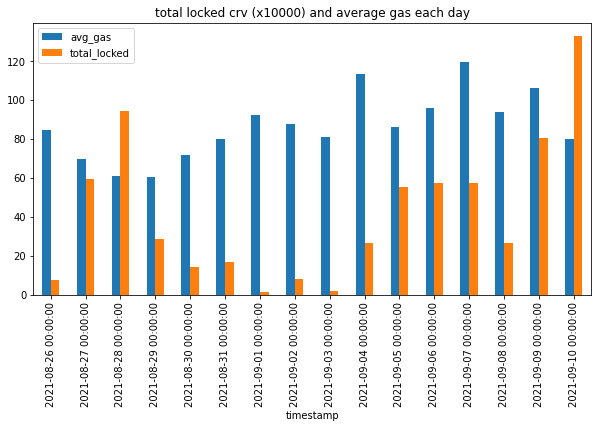

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
df_crv_lock_daily.plot(ax=ax, kind='bar')
ax.set_title("total locked crv (x10000) and average gas each day")